# Konvolúciós neurális háló

Itt is a .csv fájlok beolvasásával kezdődik a munka.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12875 entries, 0 to 12874
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     12875 non-null  object
 1   Emotion  12875 non-null  object
 2   Label    12875 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 301.9+ KB


array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

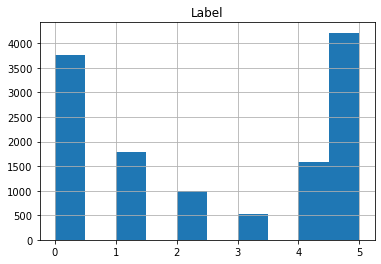

In [87]:
import pandas as pd

df_train = pd.read_csv("../data/emotions_train.csv", sep=",")
df_train.info()
df_train.head()
df_train.hist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     4292 non-null   object
 1   Emotion  4292 non-null   object
 2   Label    4292 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 100.7+ KB


array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

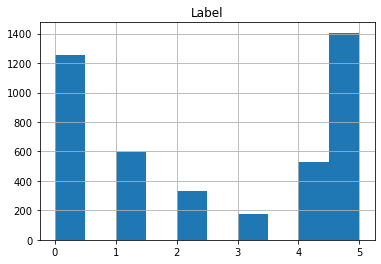

In [88]:
df_val = pd.read_csv("../data/emotions_val.csv", sep=",")
df_val.info()
df_val.head()
df_val.hist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     4292 non-null   object
 1   Emotion  4292 non-null   object
 2   Label    4292 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 100.7+ KB


array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

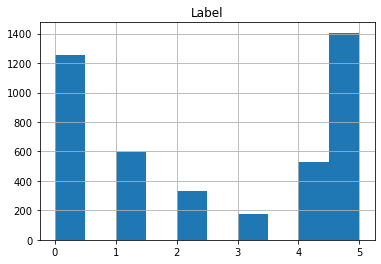

In [89]:
df_test = pd.read_csv("../data/emotions_test.csv", sep=",")
df_test.info()
df_test.head()
df_test.hist()

In [90]:
train = list(df_train["Text"].values)
val = list(df_val["Text"].values)
test = list(df_test["Text"].values)

A ```BertWordPieceTokenizer``` használatával tokeinzáljuk a szöveget.

In [91]:
import numpy as np
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt",
                                   lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

Előállítjuk a következőket: ```X_train```, ```X_val```, ```X_test``` a tokenizált szövegekből. Illetve az ```y_train```, ```y_val``` és ```y_test```-et a "Label" értékekből. Ezekre majd a ```model.fit()``` során lesz szükségünk.

In [92]:
import tensorflow as tf

maxlen = 128

X_train = bert_tokenizer(train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["Label"].values

X_val = bert_tokenizer(val)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)
y_val = df_val["Label"].values


X_test = bert_tokenizer(test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
y_test = df_test["Label"].values

Összeállítjuk a modellt amit majd szeretnénk használni. Itt a ```units=6```-ot módosítottam mivel az általam használt adathalmazban 6 különböző osztály jelenik meg így ezt 6-ra módosítottam. 1D konvolúciót fogunk használni és létrehozzuk a ```model_cnn``` modellt.

In [93]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=6, activation='softmax')
]) 

model_cnn.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 128, 32)           976736    
                                                                 
 conv1d_16 (Conv1D)          (None, 122, 32)           7200      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 18, 32)            7200      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 6)               

A taníttatás 5 epochon keresztül fog zajlani és itt is a másik neurális hálóhoz hasonlóan próbáltam valamennyire súlyozni a különböző osztályokat. a ```(monitor='val_accuracy', patience=2)``` segítségével ha a ```val_accuracy``` értéke 3 epoch után sem változik akkor befejezi a folyamatot.

In [94]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_cnn = model_cnn.fit(X_train, 
                      y_train,
                      epochs=5,
                      batch_size=32,
                      class_weight={0:1.,
                             1:2.,
                             2:3.,
                             3:6.,
                             4:3.,
                             5:1.},
                      callbacks=[callback],
                      validation_data=(X_val, y_val))

Epoch 1/5
403/403 [==============================] - 9s 19ms/step - loss: 2.9959 - accuracy: 0.2043 - val_loss: 1.4243 - val_accuracy: 0.4758
Epoch 2/5
403/403 [==============================] - 8s 19ms/step - loss: 1.6172 - accuracy: 0.7256 - val_loss: 0.5582 - val_accuracy: 0.8085
Epoch 3/5
403/403 [==============================] - 8s 19ms/step - loss: 0.6522 - accuracy: 0.8694 - val_loss: 0.5393 - val_accuracy: 0.8080
Epoch 4/5
403/403 [==============================] - 8s 19ms/step - loss: 0.3906 - accuracy: 0.9181 - val_loss: 0.5636 - val_accuracy: 0.8134
Epoch 5/5
403/403 [==============================] - 8s 19ms/step - loss: 0.2770 - accuracy: 0.9412 - val_loss: 0.6050 - val_accuracy: 0.8155


A továbbiakban láthatjuk a tanítattás eredményeit számokkal és grafikus módszerekkel reprezentálva.

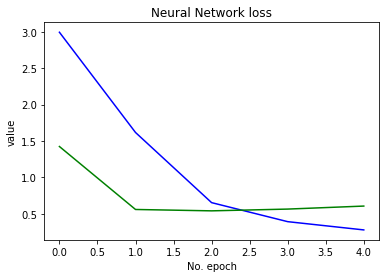

In [95]:
import matplotlib.pyplot as plt

plt.plot(h_cnn.history['loss'], label='(training data)',color='blue')
plt.plot(h_cnn.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

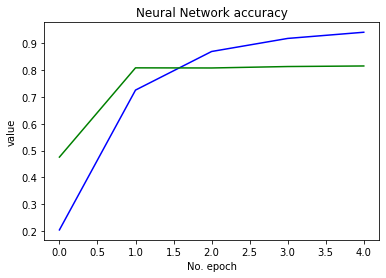

In [96]:
import matplotlib.pyplot as plt

plt.plot(h_cnn.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_cnn.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [97]:
results = model_cnn.evaluate(X_test, y_test, batch_size=32)
print("Simple cnn test loss, test acc:", results)

135/135 [==============================] - 0s 3ms/step - loss: 1.1561 - accuracy: 0.6915
Simple cnn test loss, test acc: [1.1561390161514282, 0.6915190815925598]
